## Librerías necesarias

In [50]:
import pandas as pd
import fasttext
import numpy as np
import matplotlib.pyplot as plt
import umap
import hdbscan
from sklearn.preprocessing import StandardScaler
# import umap.umap_ as umap
from  bertopic import BERTopic
from transformers import pipeline
from bertopic.representation import TextGeneration
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from transformers import pipeline
import seaborn as sns

In [70]:
df_ar = pd.read_csv("../data/cleaned_data/arabe_limpio.csv", sep="\t", encoding="utf-8")
df_ar.rename(columns={"Texto": "text", "Capítulo": "capitulo", "Versículo": "versiculo"}, inplace=True)
print(df_ar["text"].head())

eng_q = pd.read_csv('../data/cleaned_data/cleaned_english_quran.txt', 
                    sep="|", 
                    names=["capitulo", "verso", "text"],
                    engine="python",
                    quoting=3, # Necesario para evitar problemas con las comillas en el texto en inglés.
                    header=None)

df_en = pd.DataFrame(eng_q)
print(df_en["text"].head())
df_en.head()

0    بسم الله الرحمن الرحيم
1     الحمد لله رب العالمين
2             الرحمن الرحيم
3            مالك يوم الدين
4    اياك نعبد واياك نستعين
Name: text, dtype: object
0    in the name of allah the entirely merciful the...
1        all praise is due to allah lord of the worlds
2        the entirely merciful the especially merciful
3                   sovereign of the day of recompense
4         it is you we worship and you we ask for help
Name: text, dtype: object


,capitulo,verso,text
0,1,1.0,in the name of allah the entirely merciful the...
1,1,2.0,all praise is due to allah lord of the worlds
2,1,3.0,the entirely merciful the especially merciful
3,1,4.0,sovereign of the day of recompense
4,1,5.0,it is you we worship and you we ask for help


Cargamos los modelos de fasttext obtenidos en el otro notebook

In [52]:
fasttext_arabe = fasttext.load_model("../src/modelos/fasttext_arabic_busqueda_semantica.bin")

In [53]:
fasttext_english = fasttext.load_model("../src/modelos/fasttext_english_busqueda_seamantica.bin")

# Clustering de capítulos con HDBSCAN
Para este nuevo apartado, usaremos el mismo modelo de embeddings usado anteriormente (fasttext) utilizaremos UMAP para la reducción de dimensionalidad. Ya que supuestamente funciona mejor para embeddings que el PCA (usado antes) y usaremos el modelo de clustering HDBSCAN para visualizar los grupos de capítulos más similares en un espacio bidimensional.

En árabe primero:

In [54]:
df_ft = df_ar.copy()
df_ft["text"] = df_ft["text"].str.strip()
df_ft = df_ft[df_ft["text"].str.contains(r"[\u0600-\u06FF]")]
df_ft["arab_embeddings"] = df_ft["text"].apply(lambda x: fasttext_arabe.get_sentence_vector(x))
print(df_ft.dtypes)
df_ft.head()

capitulo           float64
versiculo          float64
text                object
arab_embeddings     object
dtype: object


,capitulo,versiculo,text,arab_embeddings
0,1.0,1.0,بسم الله الرحمن الرحيم,"[0.03631257, 0.0074394746, 0.013095561, -0.012..."
1,1.0,2.0,الحمد لله رب العالمين,"[0.0030007623, -0.010423319, -0.053992927, 0.0..."
2,1.0,3.0,الرحمن الرحيم,"[0.0410747, 0.017006857, 0.014440306, 0.001093..."
3,1.0,4.0,مالك يوم الدين,"[0.07585367, -0.012540054, -0.047324788, 0.019..."
4,1.0,5.0,اياك نعبد واياك نستعين,"[0.043237805, -0.02516479, -0.06165533, 0.0213..."


Ahora agrupamos los embeddings por capítulos en matrices y luego hacemos la media para poder obtener el embedding medio. Es algo similar a lo que haria fasttext pero en vez de hacer la media de los vectores de las palabras de una frase la hacemos por capítulos enteros.

In [55]:
embeddings_cap_ar = (
    df_ft.groupby("capitulo")["arab_embeddings"].apply(lambda x: np.mean(np.stack(x.values), axis=0))
    .reset_index()
)
print(f"Dimensiones de nuestro df con los embeddings agrupados por capitulos: {embeddings_cap_ar.shape}")
# 114 capítulos (filas) y 2 columnas (número del capítulo y los embeddings agrupados)
print(embeddings_cap_ar.head(5))

Dimensiones de nuestro df con los embeddings agrupados por capitulos: (114, 2)
   capitulo                                    arab_embeddings
0       1.0  [0.041730937, -0.007313849, -0.028332895, 0.00...
1       2.0  [0.035852425, -0.0048943805, -0.028815849, 0.0...
2       3.0  [0.036627408, -0.004995515, -0.027388025, 0.00...
3       4.0  [0.032175925, -0.006694064, -0.025411481, -0.0...
4       5.0  [0.037523985, -0.005679174, -0.029034786, 0.00...


Ahora reducimos la dimensionalidad de los vectores de 300 a 10 dimensiones gracias a UMAP

In [56]:
# Ahora vamos a reducir su dimensionalidad con UMAP
X = np.vstack(embeddings_cap_ar["arab_embeddings"].values) # Stackeamos verticalmente los embeddings por capítulo
X_scaled = StandardScaler().fit_transform(X) # Y escalamos

umap_reducer_ar = umap.UMAP(
    n_neighbors=5,
    min_dist=0.1, 
    n_components=10, # Lo dejaremos en 10 dimensiones para preservar mejor la información pero lo pasaremos a 2 después para una mejor visualización
    metric="cosine", # utilizaremos el cosine similarity como métrica de similitud
    random_state=42
)

X_umap = umap_reducer_ar.fit_transform(X_scaled)

Agrupación con HDBSCAN

In [57]:
hdbscan_ar = hdbscan.HDBSCAN(
    min_cluster_size = 3, # tamaño mínimo del cluster
    metric = "euclidean", # distancia euclidiana
    cluster_selection_epsilon = 0.05,
    cluster_selection_method = "leaf"
)

labels = hdbscan_ar.fit_predict(X_umap) # Labels predecidos por
embeddings_cap_ar["cluster"] = labels

Imprimimos los clusters que se han creado y los capítulos que no tienen cluster

In [58]:
for c in sorted(embeddings_cap_ar["cluster"].unique()):
    if c == -1: # No ha encontrado cluster el capítulo
        print(f"Capítulos sin cluster: {embeddings_cap_ar.loc[embeddings_cap_ar['cluster'] == c, 'capitulo'].tolist()}")
    else:
        print(f"Cluster {c}: {embeddings_cap_ar.loc[embeddings_cap_ar['cluster'] == c, 'capitulo'].tolist()}")

Capítulos sin cluster: [6.0, 10.0, 11.0, 25.0, 26.0, 34.0, 49.0, 50.0, 66.0, 76.0, 84.0, 85.0, 95.0, 103.0, 104.0, 105.0, 111.0, 112.0]
Cluster 0: [55.0, 74.0, 75.0, 78.0, 79.0, 80.0, 88.0, 89.0, 91.0, 92.0, 99.0]
Cluster 1: [53.0, 81.0, 87.0, 113.0]
Cluster 2: [1.0, 67.0, 86.0, 97.0, 106.0, 108.0, 114.0]
Cluster 3: [13.0, 14.0, 31.0, 35.0, 42.0, 100.0, 110.0]
Cluster 4: [8.0, 9.0, 47.0, 58.0, 59.0, 63.0, 98.0]
Cluster 5: [2.0, 3.0, 5.0, 60.0, 61.0]
Cluster 6: [71.0, 82.0, 101.0, 109.0]
Cluster 7: [7.0, 15.0, 37.0, 38.0, 40.0, 44.0, 51.0, 54.0, 56.0, 68.0, 77.0, 83.0, 102.0]
Cluster 8: [4.0, 24.0, 33.0, 48.0, 65.0]
Cluster 9: [22.0, 57.0, 62.0, 64.0]
Cluster 10: [16.0, 30.0, 39.0, 45.0]
Cluster 11: [21.0, 23.0, 27.0, 28.0, 29.0, 36.0, 41.0, 43.0, 46.0]
Cluster 12: [32.0, 52.0, 70.0, 107.0]
Cluster 13: [12.0, 19.0, 20.0, 69.0]
Cluster 14: [17.0, 18.0, 72.0, 90.0]
Cluster 15: [73.0, 93.0, 94.0, 96.0]


Mostramos los resultados:

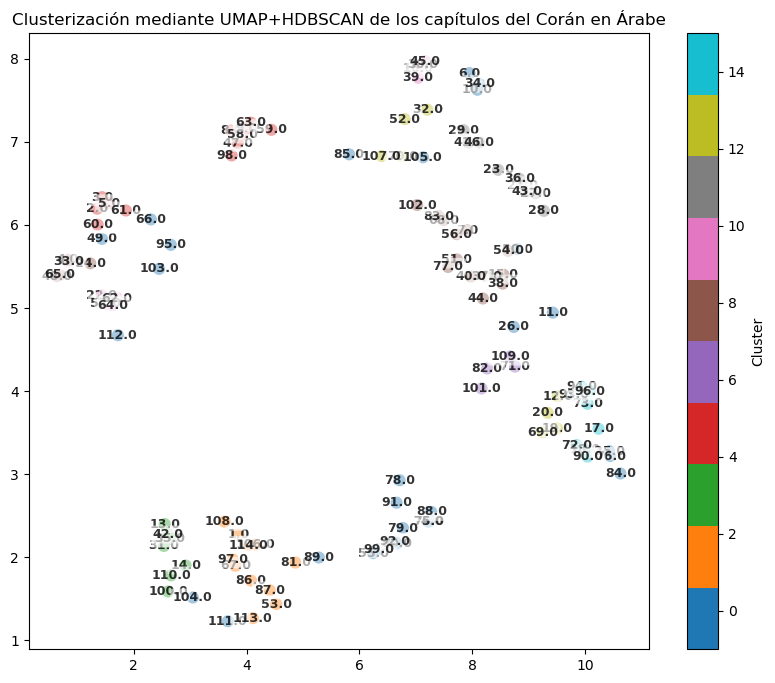

In [59]:
reducer_2d = umap.UMAP(
    n_neighbors=5, 
    min_dist=0.1, 
    n_components=2, # ahora sí lo pasamos a 2 dimensiones
    metric="cosine", 
    random_state=42
)
X_2D_ar = reducer_2d.fit_transform(X_scaled)

plt.figure(figsize=(10,8))
plt.scatter(X_2D_ar[:,0], X_2D_ar[:,1], c=labels, cmap="tab10", s=60)
for i, cap in enumerate(embeddings_cap_ar["capitulo"]):
    plt.text(
        X_2D_ar[i, 0],
        X_2D_ar[i, 1],
        str(cap),
        fontsize=9,
        fontweight='bold',
        ha='center',
        va='center',
        color='black',       # color del texto
        alpha=0.8,
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.2')
    )
plt.title("Clusterización mediante UMAP+HDBSCAN de los capítulos del Corán en Árabe")
plt.colorbar(label="Cluster")
plt.show()

En el caso de la clusterización de capítulos en inglés, lo haremos directamente ya que lo hemos explicado más detenidamente en el ejemplo árabe.

In [72]:
df_en = df_en.dropna(subset=["text"])
df_en = df_en[df_en["text"].str.strip() != ""]
df_en["text"] = df_en["text"].astype(str)
print(df_en["text"].head())
df_en["eng_embeddings"] = df_en["text"].apply(lambda x: fasttext_english.get_sentence_vector(x))
df_en["capitulo"] = pd.to_numeric(df_en["capitulo"], errors="coerce").fillna(0).astype(int)
df_en["verso"] = pd.to_numeric(df_en["verso"], errors="coerce").fillna(0).astype(int)
df_en = df_en[df_en["verso"] != 0]
df_en.drop(columns=["text"], inplace=True)
df_en.head()

0    in the name of allah the entirely merciful the...
1        all praise is due to allah lord of the worlds
2        the entirely merciful the especially merciful
3                   sovereign of the day of recompense
4         it is you we worship and you we ask for help
Name: text, dtype: object


,capitulo,verso,eng_embeddings
0,1,1,"[-0.027756814, -0.030271927, -0.0037039993, -0..."
1,1,2,"[0.0012205791, -0.015658868, 0.001786625, 0.01..."
2,1,3,"[-0.060177997, -0.035889216, 0.018935863, -0.0..."
3,1,4,"[0.012451093, -0.007927477, -0.0095781125, 0.0..."
4,1,5,"[0.016558215, 0.0019790933, -0.009872921, 0.02..."


Hacemos el mismo proceso que con el arabe

Dimensiones de nuestro df con los embeddings agrupados por capitulos: (114, 2)
Capítulos sin cluster: [23, 25, 36, 38, 53, 55, 66, 72, 73, 79, 87, 89, 91, 93, 95, 104, 106]
Cluster 0: [44, 50, 51, 54, 77, 105]
Cluster 1: [1, 13, 14, 22, 30, 31, 35, 42, 57, 59, 62, 64, 110]
Cluster 2: [52, 82, 83, 102]
Cluster 3: [6, 10, 29, 32, 34, 39, 40, 41, 45, 46, 67]
Cluster 4: [4, 24, 33, 48, 65]
Cluster 5: [2, 3, 5, 8, 9, 16, 47, 49, 58, 60, 61, 63, 98, 107]
Cluster 6: [81, 85, 97, 100, 113, 114]
Cluster 7: [7, 15, 21, 37, 43, 68]
Cluster 8: [17, 18, 71]
Cluster 9: [11, 12, 19, 20, 26, 27, 28, 94, 96, 108, 109]
Cluster 10: [56, 70, 76, 78, 80, 88, 90, 92, 101, 111, 112]
Cluster 11: [69, 74, 75, 84, 86, 99, 103]


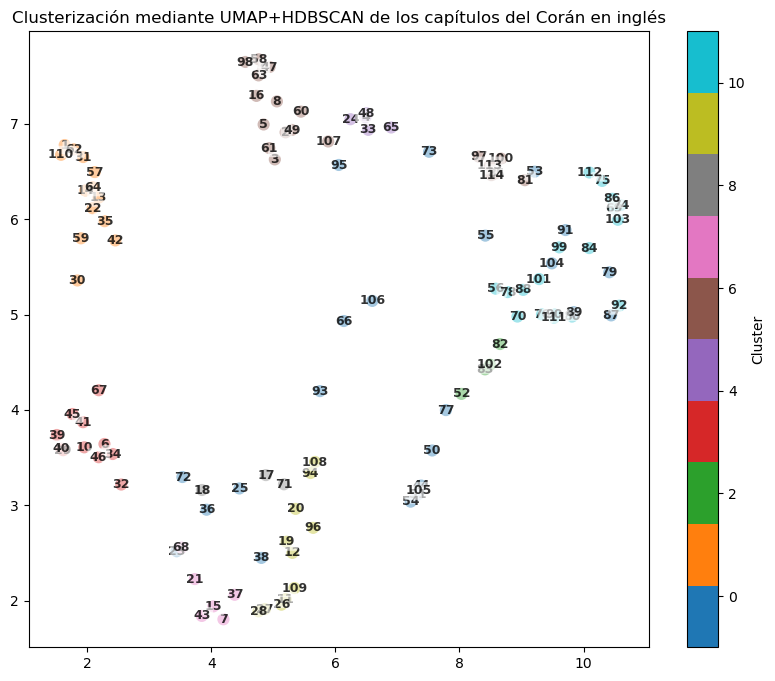

In [76]:
embeddings_cap_eng = (
    df_en.groupby("capitulo")["eng_embeddings"].apply(lambda x: np.mean(np.stack(x.values), axis=0))
    .reset_index()
)
print(f"Dimensiones de nuestro df con los embeddings agrupados por capitulos: {embeddings_cap_eng.shape}")
# 114 capítulos (filas) y 2 columnas (número del capítulo y los embeddings agrupados)
X = np.vstack(embeddings_cap_eng["eng_embeddings"].values) # Stackeamos verticalmente los embeddings por capítulo
X_scaled = StandardScaler().fit_transform(X) # Y escalamos

umap_reducer_eng = umap.UMAP(
    n_neighbors=5,
    min_dist=0.1, 
    n_components=10, # Lo dejaremos en 10 dimensiones para preservar mejor la información pero lo pasaremos a 2 después para una mejor visualización
    metric="cosine", # utilizaremos el cosine similarity como métrica de similitud
    random_state=42
)

X_umap = umap_reducer_eng.fit_transform(X_scaled)

hdbscan_eng = hdbscan.HDBSCAN(
    min_cluster_size = 3, # tamaño mínimo del cluster
    metric = "euclidean", # distancia euclidiana
    cluster_selection_epsilon = 0.05,
    cluster_selection_method = "leaf"
)

labels = hdbscan_eng.fit_predict(X_umap) # Labels predecidos por
embeddings_cap_eng["cluster"] = labels

for c in sorted(embeddings_cap_eng["cluster"].unique()):
    if c == -1: # No ha encontrado cluster el capítulo
        print(f"Capítulos sin cluster: {embeddings_cap_eng.loc[embeddings_cap_eng['cluster'] == c, 'capitulo'].tolist()}")
    else:
        print(f"Cluster {c}: {embeddings_cap_eng.loc[embeddings_cap_eng['cluster'] == c, 'capitulo'].tolist()}")
        
reducer_2d = umap.UMAP(
    n_neighbors=5, 
    min_dist=0.1, 
    n_components=2, # ahora sí lo pasamos a 2 dimensiones
    metric="cosine", 
    random_state=42
)
X_2D_eng = reducer_2d.fit_transform(X_scaled)

plt.figure(figsize=(10,8))
plt.scatter(X_2D_eng[:,0], X_2D_eng[:,1], c=labels, cmap="tab10", s=60)
for i, cap in enumerate(embeddings_cap_eng["capitulo"]):
    plt.text(
        X_2D_eng[i, 0],
        X_2D_eng[i, 1],
        str(cap),
        fontsize=9,
        fontweight='bold',
        ha='center',
        va='center',
        color='black',       # color del texto
        alpha=0.8,
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.2')
    )
plt.title("Clusterización mediante UMAP+HDBSCAN de los capítulos del Corán en inglés")
plt.colorbar(label="Cluster")
plt.show()

## Comparación de Resultados del Clustering
Después de obtener los resultados, vamos a comparar cuáles capítulos se mantienen en el mismo grupo tanto en inglés como en árabe y cuáles cambian de posición en nuestro espacio bidimensional.

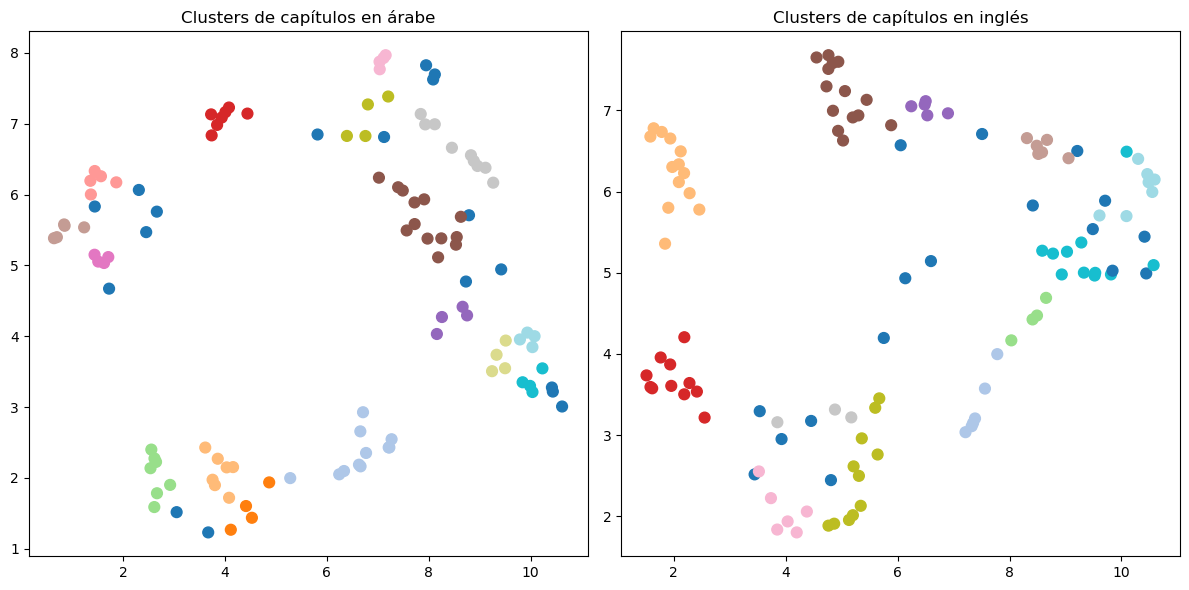

In [77]:
compare_df = embeddings_cap_ar[["capitulo", "cluster"]].merge(embeddings_cap_eng[["capitulo", "cluster"]], on="capitulo", suffixes=("_ar", "_eng"))
# En esta línea creamos una columna binaria para ver qué capítulos cambian o no de cluster respecto al idioma
compare_df["cambio"] = compare_df["cluster_ar"] != compare_df["cluster_eng"] 

fig, axes = plt.subplots(1, 2, figsize=(12,6))

axes[0].scatter(
    X_2D_ar[:,0], X_2D_ar[:,1],
    c = embeddings_cap_ar["cluster"], cmap="tab20", s=60
)
axes[0].set_title("Clusters de capítulos en árabe")

axes[1].scatter(
    X_2D_eng[:,0], X_2D_eng[:,1],
    c = embeddings_cap_eng["cluster"], cmap="tab20", s=60
)
axes[1].set_title("Clusters de capítulos en inglés")
plt.tight_layout()
plt.show()


En esta comparación lado a lado podemos ver la diferente distribución de clusters, y como podemos ver no hay mucha similitud. Contamos con 15 clusters árabes y 11 ingleses.

Text(120.72222222222221, 0.5, 'Cluster en Árabe (15 Clusters)')

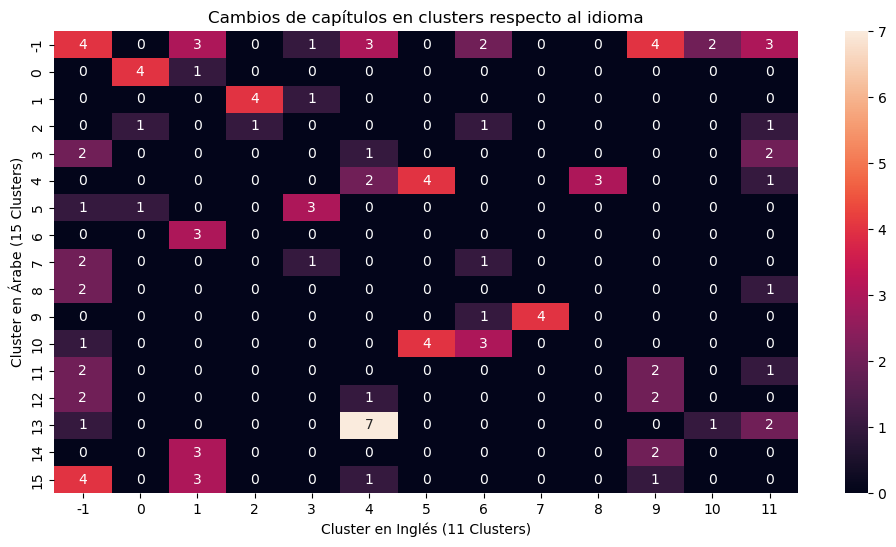

In [ ]:
cambios = pd.crosstab(compare_df["cluster_ar"], compare_df["cluster_eng"])
plt.figure(figsize=(12, 6))
sns.heatmap(cambios, annot=True)
plt.title("Cambios de capítulos en clusters respecto al idioma")
plt.xlabel("Cluster en Inglés (11 Clusters)")
plt.ylabel("Cluster en Árabe (15 Clusters)")

Text(0.5, 0.98, 'Plot de los capítulos que han sí y no han cambiado de cluster entre idiomas\nVerde: ha cambiado\nRojo: no ha cambiado')

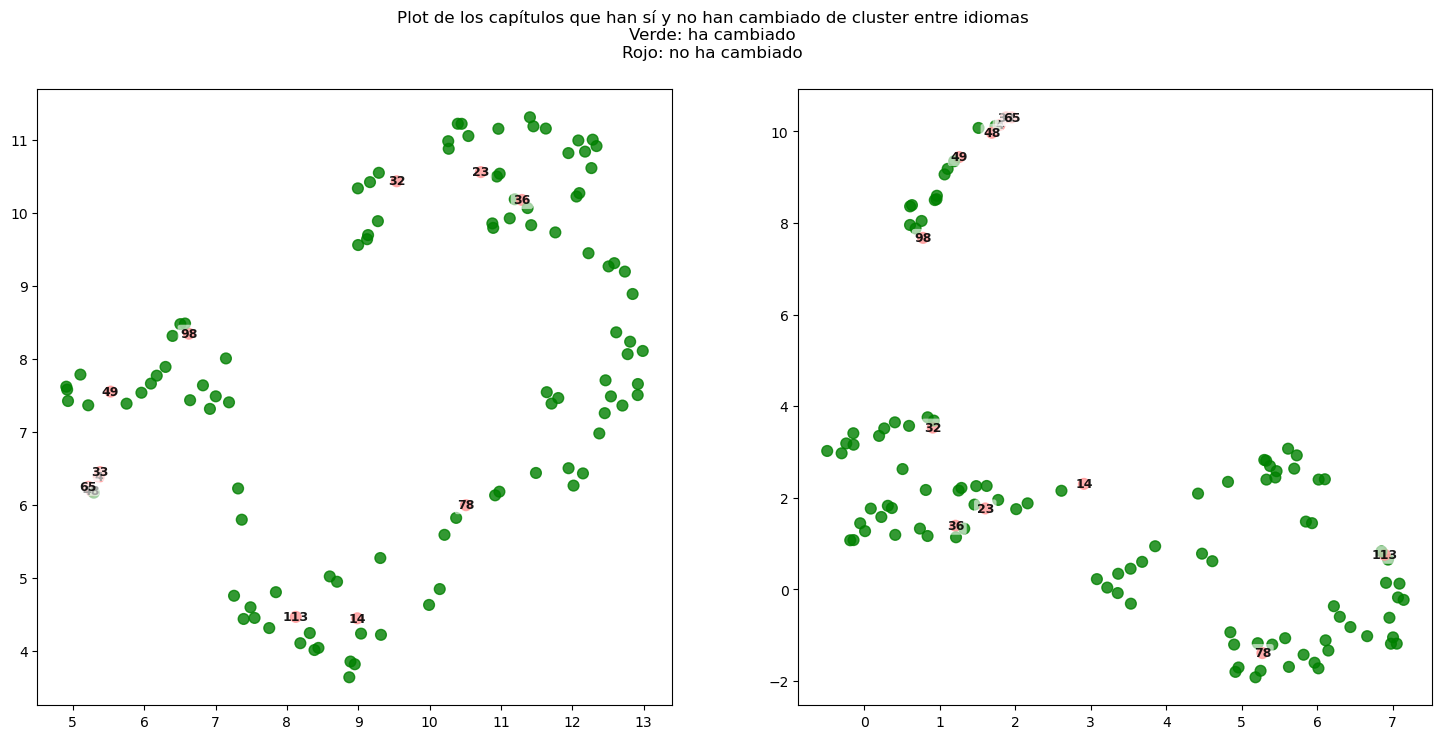

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8)) 

ax = axes[0]
scatter_ar = ax.scatter(
    X_2D_ar[:, 0],
    X_2D_ar[:, 1],
    c=compare_df["cambio"].map({True: "green", False: "red"}),
    s=60,
    alpha=0.8
)

for i, row in compare_df.iterrows():
    if row["cambio"] == False:
        ax.text(
            X_2D_ar[i, 0],
            X_2D_ar[i, 1],
            str(row["capitulo"]),
            fontsize=9,
            fontweight='bold',
            ha='center',
            va='center',
            color='black',
            alpha=0.9,
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.2')
        )


ax = axes[1]
scatter_eng = ax.scatter(
    X_2D_eng[:, 0],
    X_2D_eng[:, 1],
    c=compare_df["cambio"].map({True: "green", False: "red"}),
    s=60,
    alpha=0.8
)

for i, row in compare_df.iterrows():
    if row["cambio"] == False:
        ax.text(
            X_2D_eng[i, 0],
            X_2D_eng[i, 1],
            str(row["capitulo"]),
            fontsize=9,
            fontweight='bold',
            ha='center',
            va='center',
            color='black',
            alpha=0.9,
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.2')
        )

plt.suptitle("Plot de los capítulos que han sí y no han cambiado de cluster entre idiomas\nVerde: ha cambiado\nRojo: no ha cambiado")

Como podemos apreciar, sólo 10 capítulos de 114 han cambiado de cluster al realizar agrupaciones en diferentes idiomas. Los capítulos 33, 65, 98, 113, 14, 78, 32, 23 y 36. 

Esto se debe a que seguramente los embeddings de los capítulos que no hayan cambiado de cluster serán muy similares en inglés y árabe por similitud semántico. Puede ser por factores como un contenido muy único y característico, con palabras que no se repitan en otros capítulos. Tomemos por ejemplo el capítulo 113:

```text
113|1|say i seek refuge in the lord of daybreak
113|2|from the evil of that which he created
113|3|and from the evil of darkness when it settles
113|4|and from the evil of the blowers in knots
113|5|and from the evil of an envier when he envies
```

Donde se trata un tema muy concreto: la protección contra la maldad y la envidia. Capítulo que contiene términos como "Lord of daybreak" que son muy distintivas, que no se repetirán mucho en otros capítulos.

Por otro lado, los otros 104 capítulos restantes habrán cambiado de cluster por tener un contenido más genérico y repetido durante toda la escritura.

# Topic Modelling de los Capítulos del Corán
En esta segunda sección de este notebook, trabajaremos con BERTopic para intentar extraer información sobre los topics (o temas) que representan mejor los capítulos del texto sagrado. Aprovecharemos el modelo de embeddings fasttext (anteriormente utilizado) y el modelo UMAP para reducir la dimensión de los embeddings. Finalmente, intentaremos englobar cada tema con un label, simulando un título ficticio. Seguiremos el mismo proceso, profundizaremos en la explicación del desarrollo en árabe y lo haremos más directamente para nuestros ejemplos en inglés. 

Topic Modelling en árabe, pero tenemos que preparar el formato correcto primero:
- 'textos': con todos los textos (versículos) concatenados por capítulo (en el notebook correspondiente se usa 'abstracts')
- 'embeddings': los embeddings en forma de lista

In [ ]:
textos_ar = (
    df_ft.groupby("capitulo")["texto"]
    .apply(lambda x: " ".join(x)) # concatenación
    .tolist()
)

embeddings_ar = np.stack(embeddings_cap_ar["arab_embeddings"].values)

In [ ]:
# Stopwords en árabe, una lista arbitraria
stopwords_ar = list(stopwords.words('arabic'))
ar_vectorizer = CountVectorizer(stop_words=stopwords_ar)

In [ ]:
bertopic_ar = BERTopic(
    embedding_model = fasttext_arabe,
    umap_model = umap_reducer_ar,
    hdbscan_model = hdbscan_ar,
    vectorizer_model= ar_vectorizer,
    verbose = True
).fit(textos_ar, embeddings_ar)

2025-11-08 10:36:34,933 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-08 10:36:35,051 - BERTopic - Dimensionality - Completed ✓
2025-11-08 10:36:35,052 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-08 10:36:35,055 - BERTopic - Cluster - Completed ✓
2025-11-08 10:36:35,057 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-08 10:36:35,148 - BERTopic - Representation - Completed ✓


In [ ]:
bertopic_ar.visualize_barchart()

Como ahora mismo no podemos entender nada, trabajaremos el ejemplo en inglés y usaremos funcionalidades para traducir y comparar los resultados en ambos idiomas.

Ejemplo en inglés, mismo procedimiento:

In [ ]:
textos_eng = (
    df_en.groupby("capitulo")["texto"]
    .apply(lambda x: " ".join(x))
    .tolist()
)

embeddings_eng = np.stack(embeddings_cap_eng["eng_embeddings"].values)

# Para que no nos salgan stopwords como más predominantes
stopwords_en = list(stopwords.words("english"))
en_vectorizer = CountVectorizer(stop_words=stopwords_en)

bertopic_eng = BERTopic(
    embedding_model = fasttext_english,
    umap_model = umap_reducer_eng,
    hdbscan_model = hdbscan_eng,
    vectorizer_model=en_vectorizer,
    verbose = True
).fit(textos_eng, embeddings_eng)

bertopic_eng.visualize_barchart()

2025-11-08 10:36:37,029 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-08 10:36:37,150 - BERTopic - Dimensionality - Completed ✓
2025-11-08 10:36:37,151 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-08 10:36:37,155 - BERTopic - Cluster - Completed ✓
2025-11-08 10:36:37,157 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-08 10:36:37,236 - BERTopic - Representation - Completed ✓


Como vemos, los valores son casi los mismos para todos los topics.

## Generación de títulos para cada topic
Usaremos el modelo 'Flan-T5' para esto.

In [ ]:
generador_titulo = pipeline("text2text-generation", model="google/flan-t5-small")


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Usaremos el mismo propmt que en el notebook original

In [ ]:
prompt = """I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS].
Based on the documents and keywords, provide a concise label (max 10 words) describing this topic."""

In [ ]:
modelo_representacion = TextGeneration(
    generador_titulo,
    prompt = prompt,
    doc_length = 50,
    tokenizer = "whitespace"
)

topics_originales = bertopic_eng.get_topic_info().copy()

bertopic_eng.update_topics(textos_eng, representation_model=modelo_representacion)

def diferentes_topics(modelo, topics_originales):
    nuevos_topics = modelo.get_topic_info()
    for i in range(len(nuevos_topics)):
        new_label = nuevos_topics.loc[i, "Name"]
        old_label = topics_originales.loc[i, "Name"] if i < len(topics_originales) else ""
        print(f"Topic {i}:\n  Original: {old_label}\n  Nuevo: {new_label}\n")

100%|██████████| 15/15 [00:04<00:00,  3.04it/s]


In [ ]:
diferentes_topics(bertopic_eng, topics_originales)

Topic 0:
  Original: -1_indeed_lord_day_allah
  Nuevo: -1_alif lam ra___

Topic 1:
  Original: 0_say_allah_lord_indeed
  Nuevo: 0_allah the exalted in might the wise indeed we have sent down to you the book___

Topic 2:
  Original: 1_allah_indeed_people_upon
  Nuevo: 1_allah and his messenger to those with whom you had made a treaty among the poly___

Topic 3:
  Original: 2_allah_ever_women_upon
  Nuevo: 2_allah, o muhammad___

Topic 4:
  Original: 3_said_joseph_indeed_father
  Nuevo: 3_kaf ha ya ayn sad___

Topic 5:
  Original: 4_allah_earth_heavens_indeed
  Nuevo: 4_allah___

Topic 6:
  Original: 5_lord_said_us_indeed
  Nuevo: 5_ya seen by the wise qur an indeed you o muhammad are from___

Topic 7:
  Original: 6_said_indeed_lord_people
  Nuevo: 6_ta seen meem___

Topic 8:
  Original: 7_lord_ever_say_except
  Nuevo: 7_o you who wraps himself in clothing arise to pray the night except for a little___

Topic 9:
  Original: 8_favors_deny_lord_would
  Nuevo: 8_lord___

Topic 10:
  Origina